In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [2]:
im1 = cv.imread("images/boat1.jpg", 0)
im2 = cv.imread("images/boat3.jpg", 0)

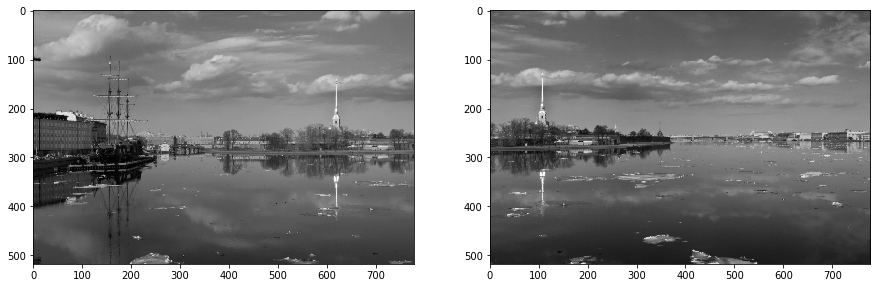

In [3]:
plt.figure(figsize=(15,10))

plt.subplot(121)
plt.imshow(im1, cmap='gray')
plt.subplot(122)
plt.imshow(im2, cmap='gray')

plt.show()

### 1. Trovare l'omografia che descrive la trasformazione tra il <u>secondo</u> set di punti ed il <u>primo</u>

https://docs.opencv.org/3.4.2/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780

In [4]:
# Estrazione keypoint
sift = cv.xfeatures2d.SIFT_create()
(kps1, features1) = sift.detectAndCompute(im1, None)
(kps2, features2) = sift.detectAndCompute(im2, None)
# Match features
bf = cv.BFMatcher(crossCheck=True)
matches = bf.match(features1, features2)

In [5]:
def myHomography(kps1, kps2, matches):
    """
    This function takes the keypoints for both images (kps1 and kps2) and the matches
    but only the best 100 matches and their respective kps1 and kps2 are taken, later
    the findHomography of cv2 is used with RANSAC with a threshold = 5 for the outliers
    """
    matches = sorted(matches, key=lambda x: x.distance)[0:50]
    kps1_matches = np.array(list(map(lambda x: kps1[x.queryIdx].pt, matches)))
    kps2_matches = np.array(list(map(lambda x: kps2[x.trainIdx].pt, matches)))
    #if distance between destination and H*src > ransacReprojThreshold then it is an outlier
    #it default to 3, we set it to 5 to be more lenient
    H,_ = cv.findHomography(kps2_matches, kps1_matches, cv.RANSAC, ransacReprojThreshold=5)
    return H

In [6]:
H = myHomography(kps1, kps2, matches)
print(H)

[[ 5.66162745e-01 -2.32772925e-02  5.21754385e+02]
 [-1.51704449e-01  9.08560899e-01  3.10563907e+01]
 [-5.48141701e-04 -3.88966864e-05  1.00000000e+00]]


### 2. Applicare l'omografia alla seconda immagine

https://docs.opencv.org/3.4.2/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87

https://docs.opencv.org/3.4.2/da/d6e/tutorial_py_geometric_transformations.html

In [7]:
def myWarp(im, H, shape):
    """
    Simply warps the image using the H matrix and return an image 
    with the desired shape. 
    """
    return cv.warpPerspective(im, H, shape)

The tranformation applied by warpPerspective using the H matrix is:
$$ \tilde x,\tilde y = \Big ( \dfrac{H_{11}x+H_{12}y+H_{13}}{H_{31}x+H_{32}y+H_{33}},\dfrac{H_{21}x+H_{22}y+H_{23}}{H_{31}x+H_{32}y+H_{33}} \Big )$$

In [8]:
def transformed_coordinates(H,x,y):
    "Uses the H matrix and the trasformation described above to get trasnformed x and y"
    x_new = (H[0][0]*x+H[0][1]*y+H[0][2])/(H[2][0]*x+H[2][1]*y+H[2][2])
    y_new = (H[1][0]*x+H[1][1]*y+H[1][2])/(H[2][0]*x+H[2][1]*y+H[2][2])
    return x_new, y_new

**Here we print and see how the borders are trasformed, which will also be useful to see where to crop the image, thanks to which the collage process can be automatized to adapt to any picture it sees. And later on it will also be useful to know when does the actual image starts.**

In [9]:
x_1 = im2.shape[1]
y_1 = im2.shape[0]
print("Transformation of x:", "(" + str(x_1)+"," +str(y_1)+")", "is", transformed_coordinates(H,x_1,y_1))

Transformation of x: (778,518) is (1716.978759286146, 693.2901439167997)


In [10]:
x_2 = im2.shape[1]
y_2 = 0
print("Transformation of x:", "(" + str(x_2)+"," +str(y_2)+")", "is", transformed_coordinates(H,x_2,y_2))

Transformation of x: (778,0) is (1677.684804861963, -151.63510507502122)


In [11]:
x_3 = 0
y_3 = 0
print("Transformation of x:", "(" + str(x_3)+"," +str(y_3)+")", "is", transformed_coordinates(H,x_3,y_3))

Transformation of x: (0,0) is (521.7543845525507, 31.056390668902107)


In [12]:
x_4 = 0
y_4 = im2.shape[0]
print("Transformation of x:", "(" + str(x_4)+"," +str(y_4)+")", "is", transformed_coordinates(H,x_4,y_4))

Transformation of x: (0,518) is (520.1775355606516, 512.0071032227181)


**Here we choose the maximum of the all border points and the other image dimensions so we can stich also some non complete images (there example to explain what it means at the end of the assignment)**

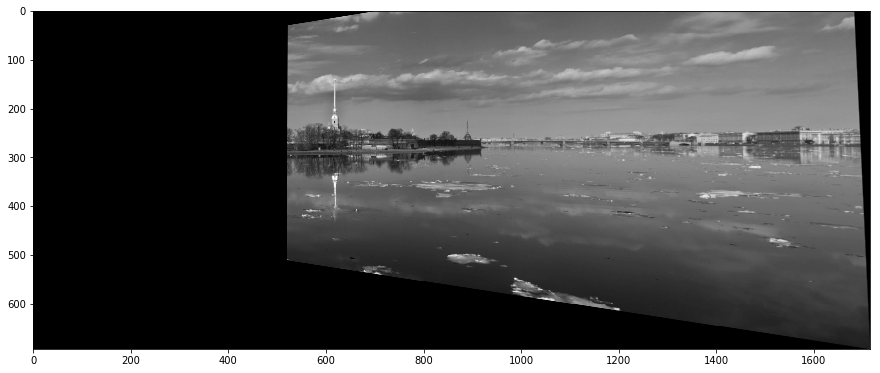

In [13]:
# Apply a perspective warp to stitch the images together
plt.figure(figsize=(15,10))
shape = (int(max(transformed_coordinates(H,x_1,y_1)[0], 
                 transformed_coordinates(H,x_2,y_2)[0],
                 transformed_coordinates(H,x_3,y_3)[0],
                 transformed_coordinates(H,x_4,y_4)[0],
                 im1.shape[1])), 
             int(max(transformed_coordinates(H,x_1,y_1)[1], 
                 transformed_coordinates(H,x_2,y_2)[1],
                 transformed_coordinates(H,x_3,y_3)[1],
                 transformed_coordinates(H,x_4,y_4)[1],
                 im1.shape[0])))
temp = myWarp(im2, H, shape)
plt.imshow(temp, cmap='gray'); plt.show()

### 3. Integrare la prima immagine

``im_base[from_y:to_y, from_x:to_x] = im_new``

In [14]:
def myCollage(im_base, im_new):
    """
    This one just puts the im_new on top of im_base nothing special,
    it assumes the im_new can be contained in im_base otherwise an
    exception will be raised.
    """
    im_base[:im_new.shape[0],:im_new.shape[1]] = im_new
    return im_base

**Finally we plot the stiched image, but there is a small problem the fact that the merging of the photos is not smooth, in fact, we can see a divider line in between**

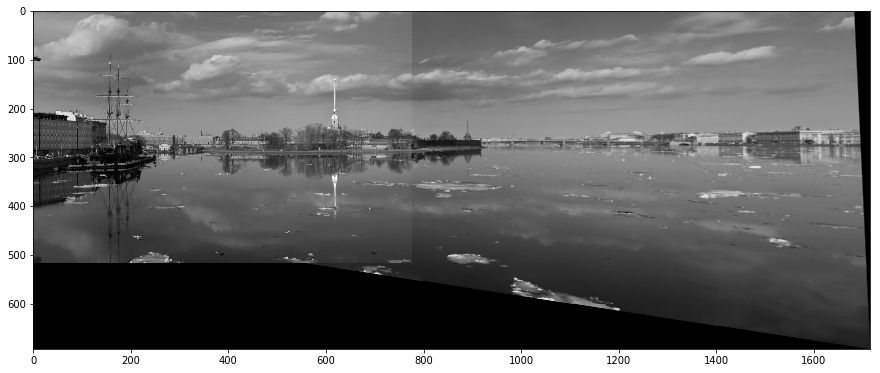

In [15]:
plt.figure(figsize=(15,10))
result = myCollage(temp, im1)
plt.imshow(result, cmap='gray'); plt.show()

### Sticher Funtion to pack everything
**A final function to stich two images toghether is created, it is completely autonomous and requires no user modification, it will crop the image to remove the black space below created due to the angle found by the perspective transformation.**

In [16]:
def sticher(im1, im2, crop=True):
    """
    We collect everything done above in a unique function, this way 
    we need to feed only two image which need to be stiched.
    """
    # Estrazione keypoint
    sift = cv.xfeatures2d.SIFT_create()
    (kps1, features1) = sift.detectAndCompute(im1, None)
    (kps2, features2) = sift.detectAndCompute(im2, None)
    # Match features
    bf = cv.BFMatcher(crossCheck=True)
    matches = bf.match(features1, features2)
    
    H = myHomography(kps1, kps2, matches)
    
    x_1, y_1 = im2.shape[1], im2.shape[0]
    x_2, y_2 = im2.shape[1], 0
    x_3, y_3 = 0, im2.shape[0]
    x_4, y_4 = 0, 0

    shape = (int(max(transformed_coordinates(H,x_1,y_1)[0], 
                 transformed_coordinates(H,x_2,y_2)[0],
                 transformed_coordinates(H,x_3,y_3)[0],
                 transformed_coordinates(H,x_4,y_4)[0],
                 im1.shape[1])), 
             int(max(transformed_coordinates(H,x_1,y_1)[1], 
                 transformed_coordinates(H,x_2,y_2)[1],
                 transformed_coordinates(H,x_3,y_3)[1],
                 transformed_coordinates(H,x_4,y_4)[1],
                 im1.shape[0])))
    
    temp = myWarp(im2, H, shape)
    
    if not crop:
        return myCollage(temp, im1)
    
    x_coord = int(min(transformed_coordinates(H,x_1,y_1)[1], 
                 transformed_coordinates(H,x_2,y_2)[1],
                 transformed_coordinates(H,x_3,y_3)[1],
                 transformed_coordinates(H,x_4,y_4)[1]))
    
    return myCollage(temp, im1)[:im1.shape[0],:x_coord]

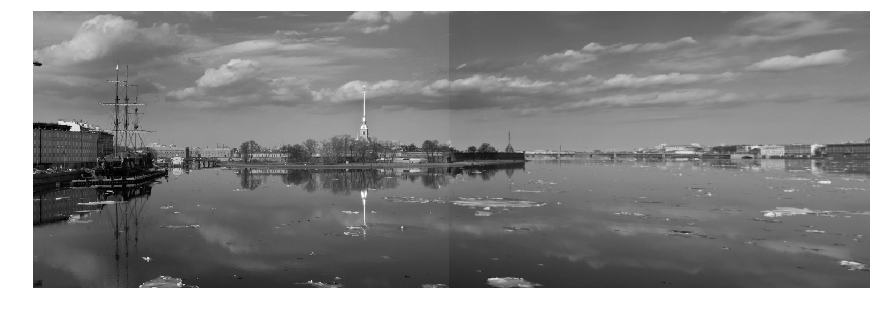

CPU times: user 1.68 s, sys: 104 ms, total: 1.78 s
Wall time: 438 ms


In [17]:
%%time
plt.figure(figsize=(15,10))
plt.imshow(sticher(im1,im2, True), cmap='gray'); plt.axis('off')
plt.show()

## Smooth Sticher
**As we said before the transition between the two images is not smooth, so a now collage maker is created: *myCollage_smooth***;

**It basically pastes the new picture until the blend_start, after which it will blend the pictures using a weighed average between the new and base image, the weight changes while be move in the image, the more we go near the base image at the right the more weight is given to the base image: at the blend_point the weight is 0 while at the end of the new picture the weight has value 1**.

In [18]:
def myCollage_smooth(im_base, im_new, blend_start):
    """
    Pastes the new picture until the blend_start, after which it will 
    blend the pictures using a weighed average between the new and base image, 
    the weight changes while be move in the image, the more we go near 
    the base image at the right the more weight is given to the base image: 
    at the blend_point the weight is 0 while at the end of the new picture the weight has value 1
    """
    im_base[:im_new.shape[0],:blend_start] = im_new[:im_new.shape[0],:blend_start]
    for w in range(blend_start,im_new.shape[1]):
        weight = (w-blend_start)/(im_new.shape[1]-blend_start)
        im_base[:im_new.shape[0],w] = (1-weight)*im_new[:,w] + weight*im_base[:im_new.shape[0],w]
    return im_base

def sticher_smooth(im1, im2, crop=True):
    """Same as the sticher function as above but uses the myCollage_smooth to blend the images"""
    # Estrazione keypoint
    sift = cv.xfeatures2d.SIFT_create()
    (kps1, features1) = sift.detectAndCompute(im1, None)
    (kps2, features2) = sift.detectAndCompute(im2, None)
    # Match features
    bf = cv.BFMatcher(crossCheck=True)
    matches = bf.match(features1, features2)
    
    H = myHomography(kps1, kps2, matches)
    
    x_1, y_1 = im2.shape[1], im2.shape[0]
    x_2, y_2 = im2.shape[1], 0
    x_3, y_3 = 0, im2.shape[0]
    x_4, y_4 = 0, 0

    shape = (int(max(transformed_coordinates(H,x_1,y_1)[0], 
                 transformed_coordinates(H,x_2,y_2)[0],
                 transformed_coordinates(H,x_3,y_3)[0],
                 transformed_coordinates(H,x_4,y_4)[0],
                 im1.shape[1])), 
             int(max(transformed_coordinates(H,x_1,y_1)[1], 
                 transformed_coordinates(H,x_2,y_2)[1],
                 transformed_coordinates(H,x_3,y_3)[1],
                 transformed_coordinates(H,x_4,y_4)[1],
                 im1.shape[0])))
    
    temp = myWarp(im2, H, shape)
    blend_start = int(min(transformed_coordinates(H,x_3,y_3)[0], 
                         transformed_coordinates(H,x_4,y_4)[0]))
    
    if not crop:
        return myCollage_smooth(temp, im1, blend_start)
    
    x_coord = int(min(transformed_coordinates(H,x_1,y_1)[1], 
                 transformed_coordinates(H,x_2,y_2)[1])) #depends only on the image on the right
    return myCollage_smooth(temp, im1, blend_start)[:im1.shape[0],:x_coord]

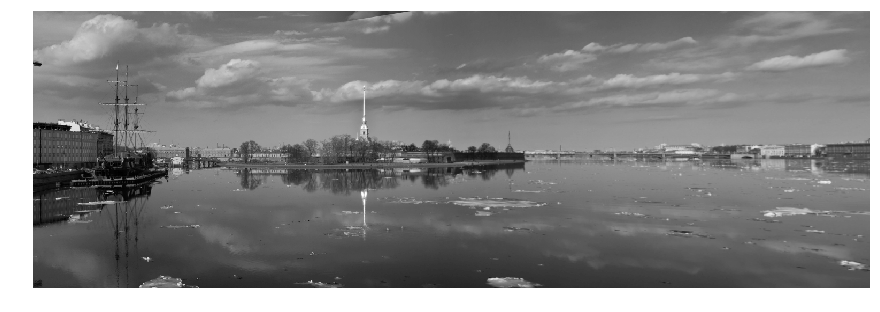

CPU times: user 1.7 s, sys: 137 ms, total: 1.84 s
Wall time: 441 ms


In [19]:
%%time
plt.figure(figsize=(15,10))
plt.imshow(sticher_smooth(im1,im2), cmap='gray'); plt.axis('off')
plt.show()

**The image is now every smooth compared to the initial naive approach of just pasting the two images above, and it is just as fast as the non-weighted one.**

## Three images
**We test the two methods with 3 images to compare them visibly**

In [20]:
im3 = cv.imread("images/boat2.jpg", 0)

**To stich the three images we stich first the two images boat1 and boat2, respectively saved in im1 and im3 variables and after thewi stich we stich the result with the boat3 (im2).**

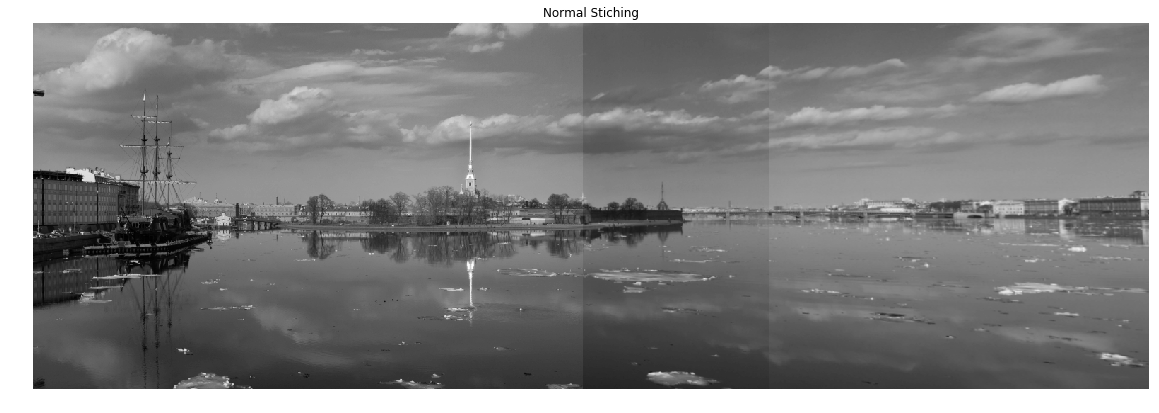

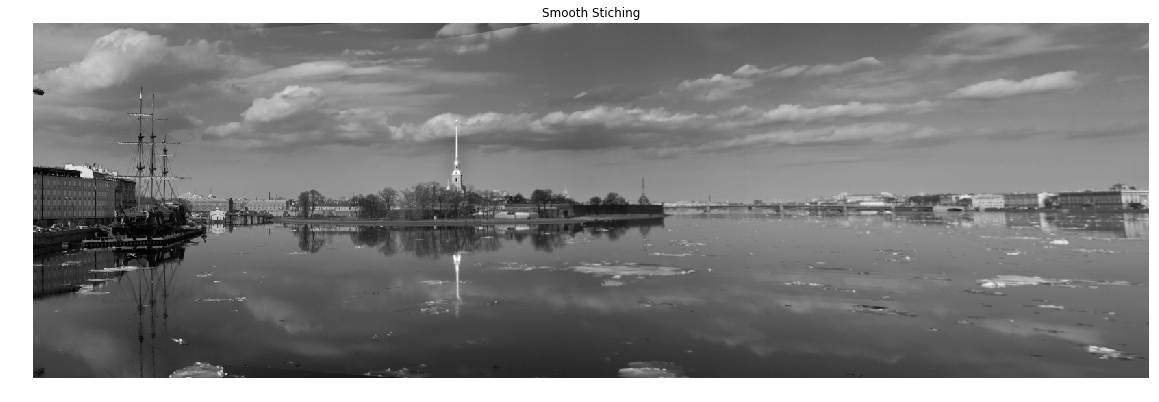

In [21]:
plt.figure(figsize=(20,12))
plt.imshow(sticher(sticher(im1,im3),im2), cmap='gray'); plt.axis('off')
plt.title("Normal Stiching")
plt.show()

plt.figure(figsize=(20,12))
plt.imshow(sticher_smooth(sticher_smooth(im1,im3),im2), cmap='gray'); plt.axis('off')
plt.title("Smooth Stiching")
plt.show()

**However there is a problem, the sticher is only able to add images to the right, if we continue adding images to the right after a certain while the images need to rotate too much making the x axis streached a lot, for example a 180 degree photo. A solution to this problem is to create also a left sticher and stich pictures alternativelty.**

In [22]:
im1 = cv.imread("images/S1.jpg", 0)
im2 = cv.imread("images/S2.jpg", 0)
im3 = cv.imread("images/S3.jpg", 0)
im4 = cv.imread("images/S4.jpg", 0)
im5 = cv.imread("images/S5.jpg", 0)

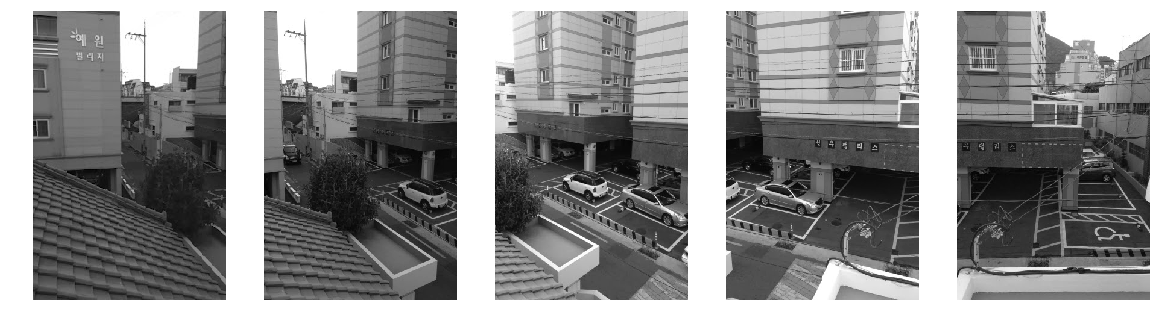

In [23]:
plt.figure(figsize=(20,15))

plt.subplot(151)
plt.imshow(im1, cmap='gray')
plt.axis('off')
plt.subplot(152)
plt.imshow(im2, cmap='gray')
plt.axis('off')
plt.subplot(153)
plt.imshow(im3, cmap='gray')
plt.axis('off')
plt.subplot(154)
plt.imshow(im4, cmap='gray')
plt.axis('off')
plt.subplot(155)
plt.imshow(im5, cmap='gray')
plt.axis('off')
plt.show()

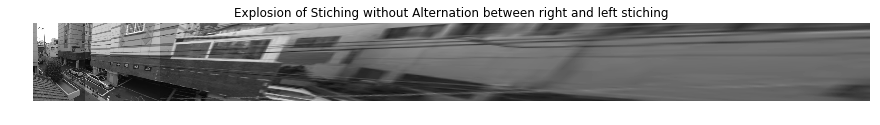

In [24]:
plt.figure(figsize=(15,15))

result = sticher(sticher(im2,sticher(im3,im4)),im5)
plt.imshow(result, cmap='gray'); plt.axis('off')
plt.title("Explosion of Stiching without Alternation between right and left stiching")
plt.show()

In [25]:
def left_sticher_smooth(im1, im2, crop=True):
    """
    Substantionally filps the two image on, then considers the im2 as left 
    image and im1 as right image, uses the already existing function and 
    flips back the result in the right position.
    """
    # Estrazione keypoint
    im1 = np.flip(im1, 1)
    im2 = np.flip(im2, 1)
    
    return np.flip(sticher_smooth(im2, im1, crop),1)

def left_sticher(im1, im2, crop=True):
    """
    Substantionally filps the two image on, then considers the im2 as left 
    image and im1 as right image, uses the already existing function and 
    flips back the result in the right position.
    """
    # Estrazione keypoint
    im1 = np.flip(im1, 1)
    im2 = np.flip(im2, 1)
    
    return np.flip(sticher(im2, im1, crop),1)

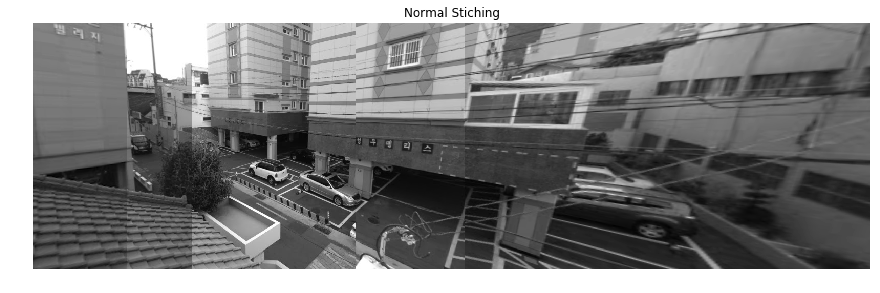

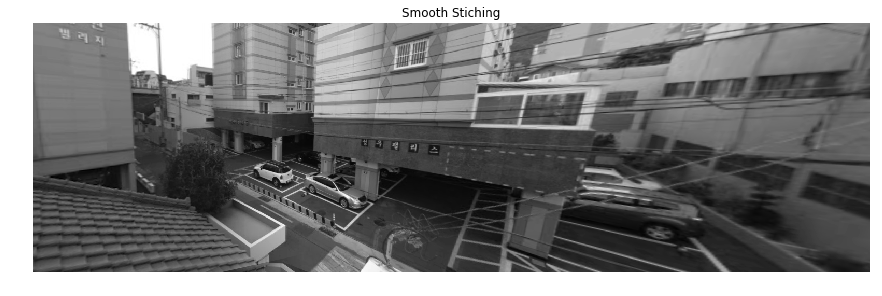

In [26]:
plt.figure(figsize=(15,15))

result = left_sticher(im1,sticher(left_sticher(im2,sticher(im3,im4)),im5))
plt.imshow(result, cmap='gray'); plt.axis('off')
plt.title("Normal Stiching")
plt.show()

plt.figure(figsize=(15,15))

result = left_sticher_smooth(im1,sticher_smooth(left_sticher_smooth(im2,sticher_smooth(im3,im4)),im5))
plt.imshow(result, cmap='gray'); plt.axis('off')
plt.title("Smooth Stiching")
plt.show()

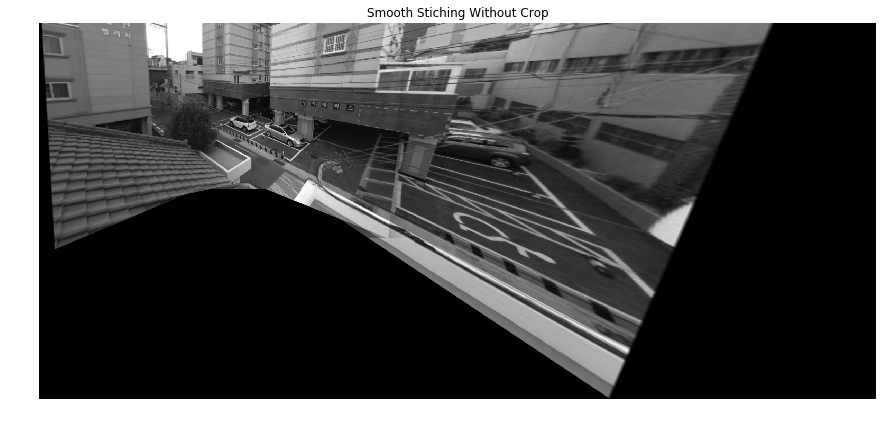

In [30]:
plt.figure(figsize=(15,15))

result = left_sticher_smooth(im1,sticher_smooth(left_sticher_smooth(im2,sticher_smooth(im3,im4, False), False),im5, False), False)
plt.imshow(result, cmap='gray'); plt.axis('off')
plt.title("Smooth Stiching Without Crop")
plt.show()